In [5]:
export AWS_ACCESS_KEY_ID="T4BAX1X62IQMCMZTSUBK"
export AWS_SECRET_ACCESS_KEY="CgJy3pJ4dZaKHdpYRY60eyhLh33sZG7PvQBUwyhO"

SyntaxError: invalid syntax (1687843164.py, line 1)

In [6]:

!aws s3 cp s3://object-bucket-ec24578-dd245d22-d551-419d-9bc5-4c77d038ce84/rating_distribution.csv ./rating_distribution --recursive

fatal error: Unable to locate credentials


In [8]:
pip install matplotlib

  Using cached matplotlib-3.10.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached contourpy-1.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.56.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (101 kB)
  Using cached kiwisolver-1.4.8-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.2 kB)
  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached pillow-11.1.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (9.1 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.6 MB)
Using cached contourpy-1.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (326 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB

In [10]:
pip install pandas


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


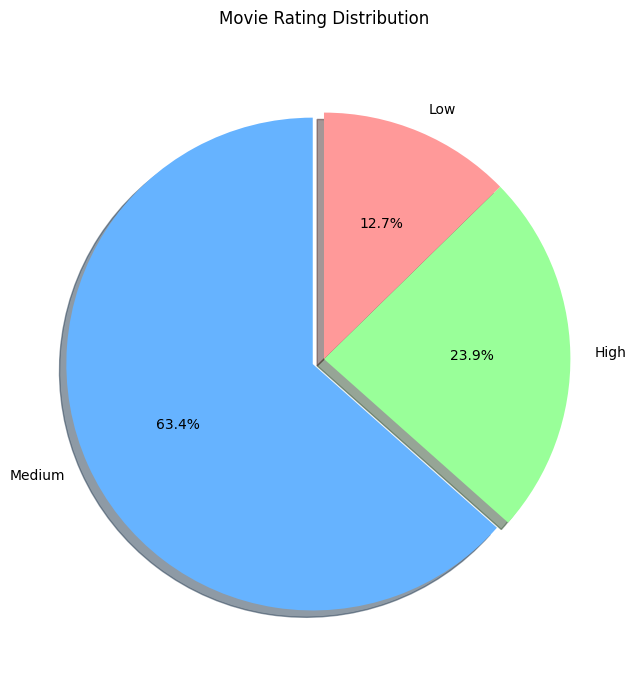

Visualization saved as 'rating_pie_chart.png'


In [11]:
import os
import boto3
import pandas as pd
import matplotlib.pyplot as plt
from botocore.client import Config

# 1. Configuration using your bucket details
S3_CONFIG = {
    "endpoint_url": "https://ceph-a-object-rgw.comp-teach.qmul.ac.uk",
    "aws_access_key_id": "T4BAX1X62IQMCMZTSUBK",
    "aws_secret_access_key": "CgJy3pJ4dZaKHdpYRY60eyhLh33sZG7PvQBUwyhO",
    "bucket_name": "object-bucket-ec24578-dd245d22-d551-419d-9bc5-4c77d038ce84",
    "prefix": "rating_distribution.csv"
}

# 2. Create S3 client
s3 = boto3.client('s3',
                endpoint_url=S3_CONFIG["endpoint_url"],
                aws_access_key_id=S3_CONFIG["aws_access_key_id"],
                aws_secret_access_key=S3_CONFIG["aws_secret_access_key"])

# 3. Download data
local_dir = "./rating_distribution"
os.makedirs(local_dir, exist_ok=True)

try:
    # List and download CSV files
    objects = s3.list_objects_v2(
        Bucket=S3_CONFIG["bucket_name"],
        Prefix=S3_CONFIG["prefix"]
    )['Contents']
    
    for obj in objects:
        if obj['Key'].endswith('.csv'):
            local_path = os.path.join(local_dir, os.path.basename(obj['Key']))
            s3.download_file(S3_CONFIG["bucket_name"], obj['Key'], local_path)
    
    # 4. Load and visualize data
    df = pd.concat([pd.read_csv(os.path.join(local_dir, f)) 
                 for f in os.listdir(local_dir) if f.endswith('.csv')])
    
    # Create pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(df['count'],
            labels=df['rating_category'],
            autopct='%1.1f%%',
            colors=['#66b3ff','#99ff99','#ff9999'],
            explode=(0.05, 0, 0),
            shadow=True,
            startangle=90)
    
    plt.title('Movie Rating Distribution', pad=20)
    plt.savefig('rating_pie_chart.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Visualization saved as 'rating_pie_chart.png'")

finally:
    # Cleanup
    del s3
    del S3_CONFIG

In [ ]:
import os
import boto3
import pandas as pd
import matplotlib.pyplot as plt
from botocore.client import Config

# 1. Download data from S3
s3 = boto3.client('s3',
    endpoint_url="https://ceph-a-object-rgw.comp-teach.qmul.ac.uk",
    aws_access_key_id="T4BAX1X62IQMCMZTSUBK",
    aws_secret_access_key="CgJy3pJ4dZaKHdpYRY60eyhLh33sZG7PvQBUwyhO",
    config=Config(signature_version='s3v4')
)

bucket = "object-bucket-ec24578-dd245d22-d551-419d-9bc5-4c77d038ce84"
prefix = "time_of_year_results"
local_dir = "./time_of_year_results"

os.makedirs(local_dir, exist_ok=True)

# Download all CSV parts
paginator = s3.get_paginator('list_objects_v2')
for page in paginator.paginate(Bucket=bucket, Prefix=prefix):
    for obj in page.get('Contents', []):
        if obj['Key'].endswith('.csv'):
            local_path = os.path.join(local_dir, os.path.basename(obj['Key']))
            s3.download_file(bucket, obj['Key'], local_path)

# 2. Load and visualize
df = pd.concat([pd.read_csv(f) for f in [
    os.path.join(local_dir, f) for f in os.listdir(local_dir) 
    if f.endswith('.csv')
]])

# Aggregate counts
counts = df.groupby('time_of_year').size().reset_index(name='counts')

# Plot
plt.figure(figsize=(8, 6))
bars = plt.bar(
    counts['time_of_year'],
    counts['counts'],
    color=['#1f77b4', '#ff7f0e'],
    width=0.6
)

# Add labels/formatting
plt.title("Ratings by Time of Year", pad=20)
plt.xlabel("Period")
plt.ylabel("Number of Ratings")
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height,
             f'{height:,}',
             ha='center', va='bottom')

plt.savefig('time_of_year_barchart.png', dpi=300, bbox_inches='tight')
plt.show()

Visualization saved to movie_ratings_distribution_pie.png


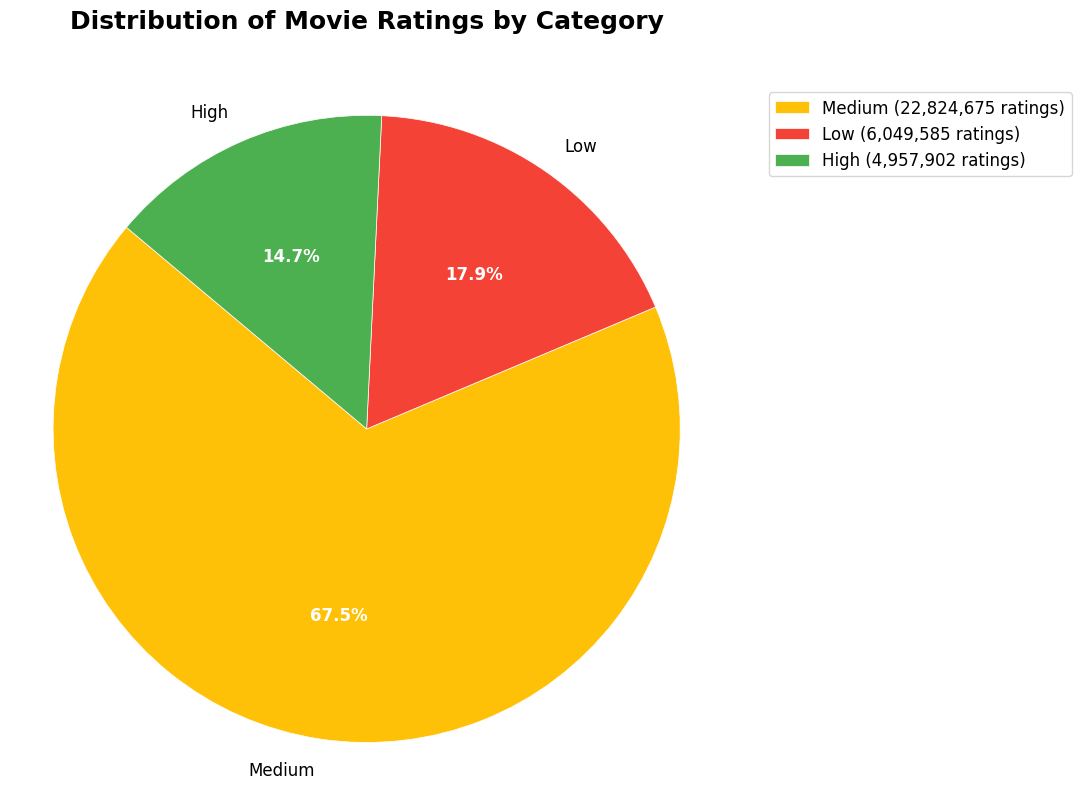

In [3]:
# Rating Distribution Pie Chart Visualization
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

# 1. Load the data from Spark output
rating_files = glob.glob('./rating_distribution/part-*.csv')  # Update path if needed
rating_df = pd.concat([pd.read_csv(f) for f in rating_files])

# 2. Data preparation - ensure proper column names
rating_df = rating_df.rename(columns={
    'rating_category': 'category',
    'count': 'count',
    'percentage': 'percentage'})

# Sort by count for better visualization
rating_df = rating_df.sort_values('count', ascending=False)

# 3. Create the pie chart
plt.figure(figsize=(12, 8))

# Define colors for each category
colors = {
    'High': '#4CAF50',    # Green
    'Medium': '#FFC107',   # Amber
    'Low': '#F44336'}      # Red  

# Get colors in order of our data
pie_colors = [colors[cat] for cat in rating_df['category']]
# Create the pie chart with percentage labels
patches, texts, autotexts = plt.pie(
    rating_df['count'],
    labels=rating_df['category'],
    colors=pie_colors,
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops={'edgecolor': 'white', 'linewidth': 0.5},
    textprops={'fontsize': 12})
# Style the percentage texts
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
plt.title('Distribution of Movie Ratings by Category\n', 
          fontsize=18, fontweight='bold', pad=20)

# Add legend with count information
legend_labels = [f'{row["category"]} ({row["count"]:,} ratings)' 
                for _, row in rating_df.iterrows()]
plt.legend(patches, legend_labels,
           loc='upper right',
           bbox_to_anchor=(1, 0, 0.5, 1),
           fontsize=12)

# Equal aspect ratio ensures the pie chart is circular
plt.axis('equal')
plt.tight_layout()
output_file = 'movie_ratings_distribution_pie.png'
plt.savefig(output_file, dpi=300, bbox_inches='tight', facecolor='white')
print(f"Visualization saved to {output_file}")
plt.show()

In [2]:
!pip install pandas
!pip install matplotlib

  Using cached pandas-2.2.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (89 kB)
  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.2.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.1 MB)
Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
  Using cached matplotlib-3.10.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached contourpy-1.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.57.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.

In [ ]:
# Time of Year Rating Distribution Visualization
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import numpy as np

# 1. Load the data from Spark output
time_files = glob.glob('./time_of_year_results/part-*.csv')  # Update path if needed
time_df = pd.concat([pd.read_csv(f) for f in time_files])

# 2. Data preparation
time_df = time_df.rename(columns={
    'time_of_year': 'period',
    'rating_count': 'count'})

# Sort by period for consistent ordering
time_df = time_df.sort_values('period')

# 3. Create the bar chart
plt.figure(figsize=(12, 8))

# Define colors and style parameters
colors = {
    'Early Year': '#3498db',  # Blue
    'Late Year': '#e74c3c'    # Red
}
bar_edge = '#2c3e50'
bar_width = 0.6

# Create the bar plot
bars = plt.bar(
    time_df['period'],
    time_df['count'],
    color=[colors[p] for p in time_df['period']],
    edgecolor=bar_edge,
    linewidth=1.5,
    width=bar_width)

# Add count labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + max(time_df['count'])*0.02,
             f'{height:,}',
             ha='center',
             va='bottom',
             fontsize=12,
             fontweight='bold')

# Add title and labels
plt.title('Movie Ratings by Time of Year\n',
          fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Time Period', fontsize=14, labelpad=12)
plt.ylabel('Number of Ratings', fontsize=14, labelpad=12)

# Customize y-axis to show full range
plt.ylim(0, max(time_df['count']) * 1.15)

# Add grid and styling
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.gca().set_facecolor('#f5f5f5')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add custom legend
legend_elements = [plt.Rectangle((0,0), 1, 1, color=colors[p], label=p) 
                   for p in time_df['period']]
plt.legend(handles=legend_elements, 
           loc='upper right',
           fontsize=12)

# Adjust layout and save
plt.tight_layout()
output_file = 'time_of_year_ratings_bar.png'
plt.savefig(output_file, dpi=300, bbox_inches='tight', facecolor='white')
print(f"Visualization saved to {output_file}")
plt.show()